In [3]:
%matplotlib inline
%load_ext rpy2.ipython

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Archimedes procedure for porous material density determination

Experimental procedure is as follow, for further detail refer to standard ASTM D7263. 

1. Measure temperature of liquid to determine its ($\rho_{\text{water}}$). Find object theoretical full density ( $\rho_{\text{solid}}$ ) and wax density ($\rho_{wax}$) from datasheet
2. Measure mass of sample(s) ($M_t$)
3. Apply two coats of wax to the sample(s)
4. Measure mass of Coated sample(s) ($M_c$)
5. Measure mass of Coated Sample(s) submerged ($M_{sub}$)


\begin{equation}
    \text{density}, \rho_b = \frac{M_t}{\frac{(M_c - M_{sub})}{\rho_{water}} - \frac{(M_c - M_t)}{\rho_{wax}}}
\end{equation}


\begin{equation}
    \text{true density}, \pi_d = \frac{ \rho_b}{\rho_{\text{solid}}} * 100
\end{equation}

Parts using two powder type are made. Parts labeled bimodal should have a higher density then parts labelled unimodal.

## Display first few row of excel sheet

In [4]:
data = pd.read_excel('./data/green_sample_benchmark.xls', sheet_name = 'wax', index_col= [0,1])
oil_density = pd.read_excel('./data/green_sample_benchmark.xls', sheet_name = 'wax_param', index_col= 0)

In [5]:
data.head()

powder type  dry weight  coated weight  wet coated  exp  operator
batch ID                                                                  
2     3      Bimodal     16.1233        16.7750     12.6154    1         1
      4      Bimodal     15.6583        16.3665     12.1851    1         1
1     1     Unimodal     14.9923        16.7300     11.3864    1         1
      5     Unimodal     15.5877        16.7838     12.0242    1         1
4     2     Unimodal     14.8018        15.4759     11.1873    2         1

## Display first few row of excel sheet

In [6]:
oil_density.head()

,wax density,water density
exp,,
1,0.961,0.997300
2,0.930,0.998020
3,0.930,0.998203


## Carrier fluid density

Density of the carrier fluid ($\rho_{\text{water}}$) is necessary for density calculation. Since the density of the fluid fluctuate depending on temperature and temperature varies from experiment to experiment, it is recorded for each experiment. For experiment 2 it was recorded at the beginning and at the end.

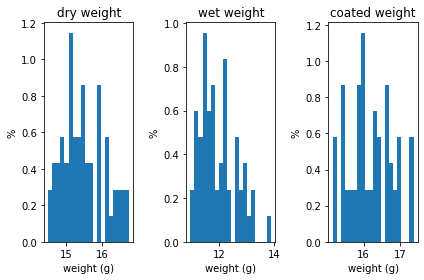

In [7]:
def plot_hist(data, b):
    fig, axes = plt.subplots(1,3)
    axes[0].hist(data['dry weight'], bins = b, density = True)
    axes[0].set_title('dry weight')
    axes[0].set_xlabel('weight (g)')
    axes[0].set_ylabel('%')

    axes[1].hist(data['wet coated'], bins = b, density = True)
    axes[1].set_title('wet weight')
    axes[1].set_xlabel('weight (g)')
    axes[1].set_ylabel('%')

    axes[2].hist(data['coated weight'], bins = b, density = True)
    axes[2].set_title('coated weight')
    axes[2].set_xlabel('weight (g)')
    axes[2].set_ylabel('%')

    plt.tight_layout()
    plt.show()

plot_hist(data, 20)

In [8]:
data = data.dropna()

## Compute density
Each sample was measured 3 times at each stage. Since we are only interested in the uncertainty in the true density ($\pi_d$), a cartesian product of each measured weights (dry, wet and coated) and liquid density is done for each sample in order to compute true density.

In [9]:

density_df = pd.DataFrame(columns = ['batch', 'id', 'density', 'operator', 'powder'])

# density of stainless steel 316L (g/cc) taken from data sheet
den_ss316 = 8.0

unique_id = 0

# iterate over each sample to do cartesian product
for idx in data.index.unique():
    sample = data.loc[idx]

    op = int(np.unique(sample['operator']).squeeze())
    powder = str(np.unique(sample['powder type']).squeeze())
    batch = idx[0]
    
    d_weight = sample['dry weight'].to_numpy()
    wc_weight = sample['wet coated'].to_numpy()
    c_weight = sample['coated weight'].to_numpy()

    exp_num = sample['exp']
    
    # density of liquid and wax taken from datasheet
    water_den = np.unique(oil_density.loc[exp_num]['water density'].to_numpy())
    wax_den = np.unique(oil_density.loc[exp_num]['wax density'].to_numpy())
    
    # cartesian product
    prod = product(d_weight, wc_weight, c_weight, water_den, wax_den)

    for d_w, wc_w, c_w, water_d, wax_d in prod:
        #compute true density refer to equation on top
        den = (d_w/((c_w - wc_w)/water_d - (c_w - d_w)/wax_d))/den_ss316*100
        new_entry = {
            'batch' : batch,
            'id' : unique_id,
            'density' : float(den.squeeze()),
            'operator' : op,
            'powder' : powder
        }

        density_df = density_df.append(new_entry, ignore_index = True)
    
    unique_id += 1

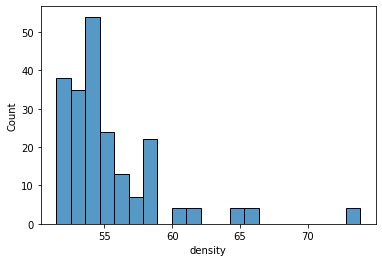

In [10]:
ax = sns.histplot(density_df['density'])

In [11]:
%%R -i density_df

library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [12]:
%%R -i density_df

fixed_lm <- lm(density ~ factor(operator) + factor(powder), data = density_df)
summary(fixed_lm)


Call:
lm(formula = density ~ factor(operator) + factor(powder), data = density_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.4506 -1.2159 -0.6900  0.2573 15.0853 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             55.3415     0.3429 161.395  < 2e-16 ***
factor(operator)2        3.4437     0.4074   8.452 4.78e-15 ***
factor(powder)Unimodal  -3.7368     0.4117  -9.077  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.962 on 210 degrees of freedom
Multiple R-squared:  0.4443,	Adjusted R-squared:  0.439 
F-statistic: 83.96 on 2 and 210 DF,  p-value: < 2.2e-16



In [13]:
%%R
anova(fixed_lm)

Analysis of Variance Table

Response: density
                  Df  Sum Sq Mean Sq F value    Pr(>F)    
factor(operator)   1  750.35  750.35  85.544 < 2.2e-16 ***
factor(powder)     1  722.65  722.65  82.386 < 2.2e-16 ***
Residuals        210 1842.02    8.77                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


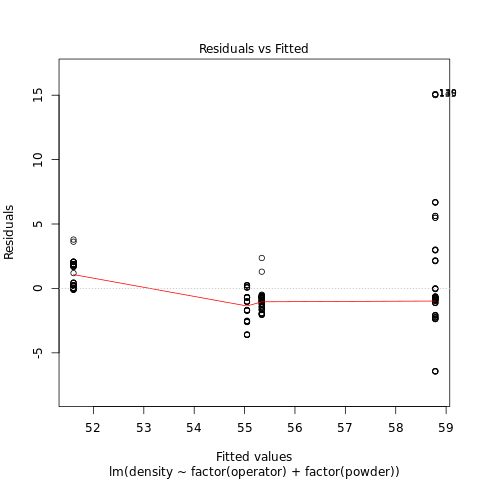

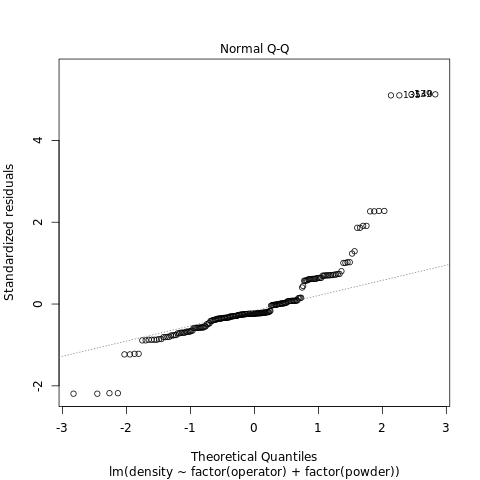

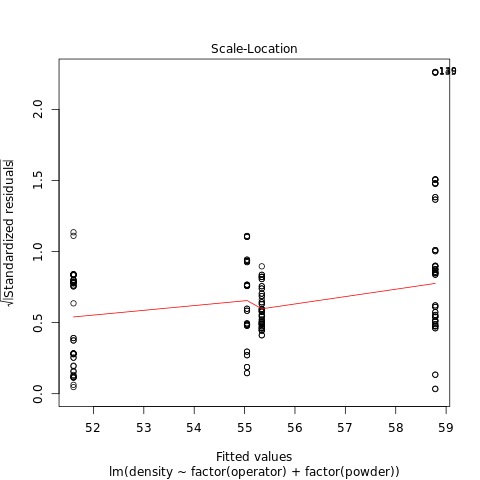

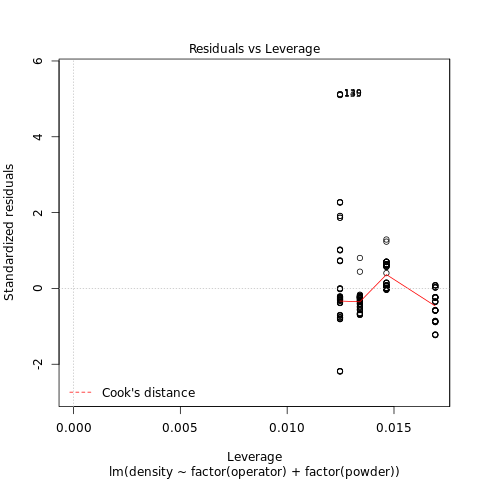

In [14]:
%%R
plot(fixed_lm)

In [15]:
%%R

mixed_lm_1 <- lmer(density ~ factor(operator) + factor(powder) + (1|id), data = density_df)
summary(mixed_lm_1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | id)
   Data: density_df

REML criterion at convergence: 959.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8623 -0.0978 -0.0335  0.0400  3.6331 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 5.160    2.272   
 Residual             3.985    1.996   
Number of obs: 213, groups:  id, 31

Fixed effects:
                       Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)             55.6288     0.7359 28.6421  75.595  < 2e-16 ***
factor(operator)2        3.0863     0.8918 27.5125   3.461 0.001775 ** 
factor(powder)Unimodal  -3.5546     0.8928 28.1350  -3.981 0.000439 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.597       
fctr(pwdr)U -0.592  0.104


In [16]:
%%R
anova(mixed_lm_1)

Type III Analysis of Variance Table with Satterthwaite's method
                 Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
factor(operator) 47.723  47.723     1 27.512  11.976 0.0017750 ** 
factor(powder)   63.164  63.164     1 28.135  15.851 0.0004388 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [17]:
%%R -i density_df

mixed_lm_2 <- lmer(density ~ factor(operator) + factor(powder) + (1|operator/id), data = density_df)
summary(mixed_lm_1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | id)
   Data: density_df

REML criterion at convergence: 959.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8623 -0.0978 -0.0335  0.0400  3.6331 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 5.160    2.272   
 Residual             3.985    1.996   
Number of obs: 213, groups:  id, 31

Fixed effects:
                       Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)             55.6288     0.7359 28.6421  75.595  < 2e-16 ***
factor(operator)2        3.0863     0.8918 27.5125   3.461 0.001775 ** 
factor(powder)Unimodal  -3.5546     0.8928 28.1350  -3.981 0.000439 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.597       
fctr(pwdr)U -0.592  0.104


In [18]:
%%R
anova(mixed_lm_2)

Type III Analysis of Variance Table with Satterthwaite's method
                 Sum Sq Mean Sq NumDF   DenDF F value    Pr(>F)    
factor(operator)  5.678   5.678     1 209.822  1.4248 0.2339586    
factor(powder)   63.164  63.164     1  28.135 15.8512 0.0004388 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [19]:
%%R -i density_df

mixed_lm_3 <- lmer(density ~ factor(operator) + factor(powder) + (1|batch), data = density_df)
summary(mixed_lm_3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: density ~ factor(operator) + factor(powder) + (1 | batch)
   Data: density_df

REML criterion at convergence: 1040.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3771 -0.4454 -0.1218  0.3147  5.1128 

Random effects:
 Groups   Name        Variance Std.Dev.
 batch    (Intercept) 2.289    1.513   
 Residual             7.454    2.730   
Number of obs: 213, groups:  batch, 8

Fixed effects:
                       Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)             55.9716     0.8811   6.1307  63.526 7.07e-10 ***
factor(operator)2        1.5947     0.5893 129.6208   2.706  0.00772 ** 
factor(powder)Unimodal  -3.3918     1.2160   5.5319  -2.789  0.03447 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) fct()2
fctr(prtr)2 -0.241       
fctr(pwdr)U -0.673 -0.038


In [21]:
%%R
anova(mixed_lm_3)

Type III Analysis of Variance Table with Satterthwaite's method
                 Sum Sq Mean Sq NumDF   DenDF F value   Pr(>F)   
factor(operator) 54.585  54.585     1 129.621  7.3229 0.007725 **
factor(powder)   57.996  57.996     1   5.532  7.7805 0.034468 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [20]:
%%R
compare_lm = anova(mixed_lm_1, mixed_lm_2, mixed_lm_3, fixed_lm)
compare_lm

R[write to console]: refitting model(s) with ML (instead of REML)

Data: density_df
Models:
fixed_lm: density ~ factor(operator) + factor(powder)
mixed_lm_1: density ~ factor(operator) + factor(powder) + (1 | id)
mixed_lm_3: density ~ factor(operator) + factor(powder) + (1 | batch)
mixed_lm_2: density ~ factor(operator) + factor(powder) + (1 | operator/id)
           Df     AIC     BIC  logLik deviance   Chisq Chi Df Pr(>Chisq)    
fixed_lm    4 1071.98 1085.42 -531.99  1063.98                              
mixed_lm_1  5  973.11  989.92 -481.56   963.11 100.863      1     <2e-16 ***
mixed_lm_3  5 1054.38 1071.19 -522.19  1044.38   0.000      0          1    
mixed_lm_2  6  975.11  995.28 -481.56   963.11  81.265      1     <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
